In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, load_iris, load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from IPython.display import clear_output, HTML, display
import time
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Enable interactive widgets for Colab
print("Setting up interactive environment for Colab...")
try:
    from google.colab import output
    output.enable_custom_widget_manager()
    IS_COLAB = True
    print("Colab environment detected and widgets enabled!")
except:
    IS_COLAB = False
    print("Not running in Colab or widgets already enabled.")

Setting up interactive environment for Colab...
Not running in Colab or widgets already enabled.


In [3]:
# Set random seed for reproducibility
np.random.seed(42)

In [4]:
# Dataset selection function
def load_dataset(dataset_name):
    if dataset_name == "synthetic":
        X, y = make_classification(
            n_samples=1000,
            n_features=10,
            n_informative=5,
            n_redundant=2,
            n_classes=2,
            random_state=42
        )
        n_classes = 2
    elif dataset_name == "iris":
        iris = load_iris()
        X, y = iris.data, iris.target
        n_classes = 3
    elif dataset_name == "digits":
        digits = load_digits()
        X, y = digits.data, digits.target
        # Use only 0-3 digits for simplicity
        mask = y < 4
        X, y = X[mask], y[mask]
        n_classes = 4
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")

    return X, y, n_classes

In [5]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.architecture = [input_size, hidden_size, output_size]

        # Initialize weights with random values
        self.weights1 = np.random.randn(self.input_size, self.hidden_size) / np.sqrt(self.input_size)
        self.weights2 = np.random.randn(self.hidden_size, self.output_size) / np.sqrt(self.hidden_size)

        # Initialize biases
        self.bias1 = np.random.randn(self.hidden_size) * 0.1
        self.bias2 = np.random.randn(self.output_size) * 0.1

        # Store activations for visualization
        self.activations = []

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))  # Clip to avoid overflow

    def relu(self, x):
        return np.maximum(0, x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X, activation_func='sigmoid'):
        # Forward propagation
        if activation_func == 'relu':
            activation = self.relu
        else:
            activation = self.sigmoid

        # Store activations
        self.activations = []

        # Layer 1
        self.z1 = np.dot(X, self.weights1) + self.bias1
        self.a1 = activation(self.z1)
        self.activations.append(self.a1)

        # Output layer
        self.z2 = np.dot(self.a1, self.weights2) + self.bias2

        # Different output activation based on output size
        if self.output_size == 1:
            self.a2 = self.sigmoid(self.z2)
        else:
            self.a2 = self.softmax(self.z2)

        self.activations.append(self.a2)
        return self.a2

    def predict(self, X, activation_func='sigmoid'):
        # Make predictions
        output = self.forward(X, activation_func)
        if self.output_size == 1:
            return (output > 0.5).astype(int)
        else:
            return np.argmax(output, axis=1)

    def get_weights(self):
        # Get all weights as a flat array
        return np.concatenate([
            self.weights1.flatten(),
            self.weights2.flatten(),
            self.bias1.flatten(),
            self.bias2.flatten()
        ])

    def set_weights(self, weights):
        # Set weights from a flat array
        start = 0
        end = self.input_size * self.hidden_size
        self.weights1 = weights[start:end].reshape(self.input_size, self.hidden_size)

        start = end
        end = start + self.hidden_size * self.output_size
        self.weights2 = weights[start:end].reshape(self.hidden_size, self.output_size)

        start = end
        end = start + self.hidden_size
        self.bias1 = weights[start:end]

        start = end
        end = start + self.output_size
        self.bias2 = weights[start:end]

    def get_total_weights(self):
        return self.input_size * self.hidden_size + self.hidden_size * self.output_size + self.hidden_size + self.output_size



In [6]:
class GeneticAlgorithm:
    def __init__(self, population_size, num_weights, mutation_rate=0.1, selection_method='tournament', crossover_method='uniform'):
        self.population_size = population_size
        self.num_weights = num_weights
        self.mutation_rate = mutation_rate
        self.selection_method = selection_method
        self.crossover_method = crossover_method
        self.population = self.initialize_population()
        self.best_individual_history = []
        self.population_diversity = []
        self.elite_size = max(1, int(population_size * 0.1))  # Keep top 10% individuals

    def initialize_population(self):
        # Initialize population with random weights
        # Use Xavier initialization for better convergence
        population = []
        for _ in range(self.population_size):
            # Initialize with smaller random values
            individual = np.random.randn(self.num_weights) * 0.1
            population.append(individual)
        return population

    def fitness(self, weights, nn, X, y, y_onehot=None):
        # Calculate fitness based on accuracy
        nn.set_weights(weights)

        if nn.output_size == 1:
            predictions = nn.predict(X)
            return accuracy_score(y, predictions)
        else:
            # For multi-class, use softmax output
            output = nn.forward(X, 'relu')
            predictions = np.argmax(output, axis=1)
            return accuracy_score(y, predictions)

    def tournament_selection(self, fitnesses, tournament_size=3):
        selected = []
        for _ in range(self.population_size):
            tournament_idx = np.random.choice(len(fitnesses), tournament_size, replace=False)
            tournament_fitness = [fitnesses[i] for i in tournament_idx]
            winner_idx = tournament_idx[np.argmax(tournament_fitness)]
            selected.append(self.population[winner_idx])
        return selected

    def roulette_wheel_selection(self, fitnesses):
        fitnesses = np.array(fitnesses)
        # Adjust fitness to handle negative values if needed
        fitnesses = fitnesses - fitnesses.min() + 1e-6
        selection_probs = fitnesses / (fitnesses.sum() + 1e-10)
        selected_indices = np.random.choice(
            range(self.population_size),
            size=self.population_size,
            p=selection_probs,
            replace=True
        )
        return [self.population[i] for i in selected_indices]

    def select_parents(self, fitnesses):
        if self.selection_method == 'tournament':
            return self.tournament_selection(fitnesses)
        else:  # Default to roulette wheel
            return self.roulette_wheel_selection(fitnesses)

    def single_point_crossover(self, parent1, parent2):
        crossover_point = np.random.randint(1, self.num_weights)
        child1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
        child2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
        return child1, child2

    def uniform_crossover(self, parent1, parent2):
        mask = np.random.random(self.num_weights) > 0.5
        child1 = np.where(mask, parent1, parent2)
        child2 = np.where(mask, parent2, parent1)
        return child1, child2

    def crossover(self, parent1, parent2):
        if self.crossover_method == 'uniform':
            return self.uniform_crossover(parent1, parent2)
        else:  # Default to single point
            return self.single_point_crossover(parent1, parent2)

    def mutate(self, individual):
        # Apply mutation with probability mutation_rate
        mutation_mask = np.random.random(self.num_weights) < self.mutation_rate

        # Use adaptive mutation - smaller mutations for more fit individuals
        mutation_values = np.random.randn(self.num_weights) * 0.1
        individual[mutation_mask] += mutation_values[mutation_mask]
        return individual

    def calculate_diversity(self):
        # Calculate population diversity as average pairwise Euclidean distance
        if self.population_size <= 1:
            return 0

        total_distance = 0
        count = 0

        # Sample pairs to estimate diversity for efficiency
        samples = min(self.population_size, 10)
        indices = np.random.choice(self.population_size, samples, replace=False)

        for i in range(len(indices)):
            for j in range(i+1, len(indices)):
                ind1 = indices[i]
                ind2 = indices[j]
                distance = np.sqrt(np.sum((self.population[ind1] - self.population[ind2])**2))
                total_distance += distance
                count += 1

        return total_distance / count if count > 0 else 0

    def evolve(self, nn, X, y, generations=50, y_onehot=None, verbose=True):
        fitness_history = []
        best_fitness = 0
        best_weights = None
        avg_fitness_history = []
        max_fitness_history = []
        diversity_history = []
        all_best_individuals = []

        progress_bar = tqdm(total=generations) if verbose else None

        for generation in range(generations):
            # Calculate fitness for each individual
            fitnesses = [self.fitness(ind, nn, X, y, y_onehot) for ind in self.population]
            avg_fitness = np.mean(fitnesses)
            max_fitness = np.max(fitnesses)
            avg_fitness_history.append(avg_fitness)
            max_fitness_history.append(max_fitness)

            # Calculate diversity
            diversity = self.calculate_diversity()
            diversity_history.append(diversity)

            # Track the best individual
            max_fitness_idx = np.argmax(fitnesses)
            current_best = self.population[max_fitness_idx].copy()
            all_best_individuals.append((current_best, fitnesses[max_fitness_idx]))

            if fitnesses[max_fitness_idx] > best_fitness:
                best_fitness = fitnesses[max_fitness_idx]
                best_weights = current_best

            # Elitism - keep best individuals
            elite_indices = np.argsort(fitnesses)[-self.elite_size:]
            elites = [self.population[i].copy() for i in elite_indices]

            # Select parents
            parents = self.select_parents(fitnesses)

            # Create next generation
            next_population = []

            # Add elites to next generation
            next_population.extend(elites)

            # Fill the rest with crossover + mutation
            while len(next_population) < self.population_size:
                # Select two parents
                parent1 = parents[np.random.randint(0, len(parents))]
                parent2 = parents[np.random.randint(0, len(parents))]

                # Crossover
                child1, child2 = self.crossover(parent1, parent2)

                # Mutation
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)

                # Add to next generation
                next_population.append(child1)
                if len(next_population) < self.population_size:
                    next_population.append(child2)

            self.population = next_population

            # Store best individual for this generation
            self.best_individual_history.append(current_best)

            # Update progress bar
            if verbose and progress_bar is not None:
                progress_bar.update(1)
                progress_bar.set_description(f"Best: {best_fitness:.4f}, Avg: {avg_fitness:.4f}")

        if verbose and progress_bar is not None:
            progress_bar.close()

        return best_weights, {
            'avg_fitness': avg_fitness_history,
            'max_fitness': max_fitness_history,
            'diversity': diversity_history,
            'best_individuals': all_best_individuals
        }


In [7]:
# Function to create animation of the optimization process
def create_optimization_animation(history, nn, X_pca, y):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create a mesh grid for visualization
    h = 0.02
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Get individuals from history
    individuals = [ind for ind, _ in history['best_individuals']]

    # Animation function
    def update(frame):
        ax.clear()
        nn.set_weights(individuals[frame])

        # Get predictions for grid points
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        Z = nn.predict(grid_points).reshape(xx.shape)

        # Plot decision boundary
        ax.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdBu)

        # Plot data points
        ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.RdBu, edgecolor='k')

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_title(f'Generation {frame+1}, Fitness: {history["best_individuals"][frame][1]:.4f}')

    # Create animation
    anim = FuncAnimation(fig, update, frames=len(individuals), interval=200)
    plt.close()  # Prevent duplicate display in notebooks

    return anim


In [8]:
# Function to plot and analyze weight dynamics
def plot_weight_dynamics(history, nn):
    individuals = [ind for ind, _ in history['best_individuals']]

    # Sample some weights to track
    n_weights_to_sample = min(10, len(individuals[0]))
    sampled_indices = np.random.choice(len(individuals[0]), n_weights_to_sample, replace=False)

    plt.figure(figsize=(12, 6))
    for idx in sampled_indices:
        weight_values = [ind[idx] for ind in individuals]
        plt.plot(weight_values, label=f'Weight {idx}')

    plt.title('Weight Values Evolution')
    plt.xlabel('Generation')
    plt.ylabel('Weight Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 3D visualization of weight evolution
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Select 3 weights to visualize
    if len(individuals[0]) >= 3:
        w1, w2, w3 = sampled_indices[:3]

        for gen, ind in enumerate(individuals):
            ax.scatter(ind[w1], ind[w2], ind[w3], color=plt.cm.viridis(gen/len(individuals)))

            # Draw lines connecting consecutive points
            if gen > 0:
                ax.plot([individuals[gen-1][w1], ind[w1]],
                        [individuals[gen-1][w2], ind[w2]],
                        [individuals[gen-1][w3], ind[w3]],
                        color='gray', alpha=0.5)

        ax.set_xlabel(f'Weight {w1}')
        ax.set_ylabel(f'Weight {w2}')
        ax.set_zlabel(f'Weight {w3}')
        ax.set_title('3D Weight Evolution Path')
        plt.show()

In [9]:
# Function to visualize neural network architecture
def visualize_nn_architecture(nn):
    # Create a figure
    fig, ax = plt.subplots(figsize=(12, 8))

    # Define layer positions
    layer_positions = [1, 3, 5]  # x-positions for each layer

    # Define node positions for each layer
    node_positions = []
    max_nodes = max(nn.architecture)

    for i, layer_size in enumerate(nn.architecture):
        positions = []
        for j in range(layer_size):
            # Center nodes vertically
            y_pos = (j - layer_size/2) / max_nodes * 10 + 5
            positions.append((layer_positions[i], y_pos))
        node_positions.append(positions)

    # Plot nodes
    for i, layer_positions in enumerate(node_positions):
        for j, (x, y) in enumerate(layer_positions):
            circle = plt.Circle((x, y), 0.2, fill=True, color='skyblue', edgecolor='blue')
            ax.add_patch(circle)

            # Label for input and output layers
            if i == 0:
                ax.text(x-0.3, y, f'x{j}')
            elif i == len(node_positions)-1 and nn.architecture[-1] > 1:
                ax.text(x+0.3, y, f'y{j}')
            elif i == len(node_positions)-1:
                ax.text(x+0.3, y, 'y')

    # Plot connections (weights)
    for i in range(len(node_positions)-1):
        for j, (x1, y1) in enumerate(node_positions[i]):
            for k, (x2, y2) in enumerate(node_positions[i+1]):
                # For first layer weights
                if i == 0:
                    weight = nn.weights1[j, k]
                # For second layer weights
                else:
                    weight = nn.weights2[j, k]

                # Determine line color and width based on weight value
                if weight > 0:
                    color = 'green'
                else:
                    color = 'red'

                # Line width proportional to weight magnitude
                width = min(abs(weight) * 3, 3)

                ax.plot([x1+0.2, x2-0.2], [y1, y2], color=color, linewidth=width, alpha=0.6)

    # Set labels for layers
    ax.text(layer_positions[0], max_nodes/2 * 10 + 1, 'Input Layer', ha='center')
    ax.text(layer_positions[1], max_nodes/2 * 10 + 1, 'Hidden Layer', ha='center')
    ax.text(layer_positions[2], max_nodes/2 * 10 + 1, 'Output Layer', ha='center')

    # Remove axes
    ax.set_xlim(0, 6)
    ax.set_ylim(0, 10)
    ax.axis('off')
    plt.title('Neural Network Architecture')
    plt.tight_layout()
    plt.show()


In [10]:
# Function to compare different optimization methods
def compare_optimization_methods(X_train, y_train, X_test, y_test, input_size, hidden_size, output_size):
    results = {}

    # Initialize neural network
    nn = NeuralNetwork(input_size, hidden_size, output_size)

    # 1. Random weights
    random_weights = nn.get_weights().copy()
    nn.set_weights(random_weights)
    random_train_acc = accuracy_score(y_train, nn.predict(X_train))
    random_test_acc = accuracy_score(y_test, nn.predict(X_test))
    results['Random'] = {'train': random_train_acc, 'test': random_test_acc}

    # 2. Genetic Algorithm with tournament selection
    ga_tournament = GeneticAlgorithm(population_size=50, num_weights=len(random_weights),
                                     selection_method='tournament', crossover_method='uniform')
    best_weights_tournament, _ = ga_tournament.evolve(nn, X_train, y_train, generations=50, verbose=False)
    nn.set_weights(best_weights_tournament)
    ga_tournament_train_acc = accuracy_score(y_train, nn.predict(X_train))
    ga_tournament_test_acc = accuracy_score(y_test, nn.predict(X_test))
    results['GA (Tournament)'] = {'train': ga_tournament_train_acc, 'test': ga_tournament_test_acc}

    # 3. Genetic Algorithm with roulette wheel selection
    ga_roulette = GeneticAlgorithm(population_size=50, num_weights=len(random_weights),
                                   selection_method='roulette', crossover_method='single')
    best_weights_roulette, _ = ga_roulette.evolve(nn, X_train, y_train, generations=50, verbose=False)
    nn.set_weights(best_weights_roulette)
    ga_roulette_train_acc = accuracy_score(y_train, nn.predict(X_train))
    ga_roulette_test_acc = accuracy_score(y_test, nn.predict(X_test))
    results['GA (Roulette)'] = {'train': ga_roulette_train_acc, 'test': ga_roulette_test_acc}

    # 4. Simplified gradient descent (for comparison)
    # This is a simplified version for illustration
    learning_rate = 0.01
    epochs = 50
    batch_size = 32

    def gradient_descent(nn, X, y, lr, epochs, batch_size):
        np.random.seed(42)
        weights = nn.get_weights().copy()
        n_batches = max(1, len(X) // batch_size)

        for _ in range(epochs):
            # Shuffle data
            indices = np.random.permutation(len(X))
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for i in range(n_batches):
                start = i * batch_size
                end = min((i + 1) * batch_size, len(X))

                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                # Numerical gradient approximation
                epsilon = 1e-7
                gradients = np.zeros_like(weights)

                # For each weight, calculate approximate gradient
                for j in range(len(weights)):
                    # Original accuracy
                    nn.set_weights(weights)
                    original_accuracy = accuracy_score(y_batch, nn.predict(X_batch))

                    # Perturb weight and calculate new accuracy
                    perturbed_weights = weights.copy()
                    perturbed_weights[j] += epsilon
                    nn.set_weights(perturbed_weights)
                    perturbed_accuracy = accuracy_score(y_batch, nn.predict(X_batch))

                    # Approximated gradient
                    gradients[j] = (perturbed_accuracy - original_accuracy) / epsilon

                # Update weights (ascent because we want to maximize accuracy)
                weights += lr * gradients

        return weights

    best_weights_gd = gradient_descent(nn, X_train, y_train, learning_rate, epochs, batch_size)
    nn.set_weights(best_weights_gd)
    gd_train_acc = accuracy_score(y_train, nn.predict(X_train))
    gd_test_acc = accuracy_score(y_test, nn.predict(X_test))
    results['Gradient Approx.'] = {'train': gd_train_acc, 'test': gd_test_acc}

    return results


In [11]:
# Function to run GA with different hyperparameters
def hypertune_ga(X_train, y_train, nn, num_weights):
    param_combinations = [
        {'population_size': 30, 'mutation_rate': 0.05, 'selection': 'tournament', 'crossover': 'single'},
        {'population_size': 30, 'mutation_rate': 0.15, 'selection': 'tournament', 'crossover': 'uniform'},
        {'population_size': 50, 'mutation_rate': 0.05, 'selection': 'tournament', 'crossover': 'single'},
        {'population_size': 50, 'mutation_rate': 0.15, 'selection': 'tournament', 'crossover': 'uniform'},
        {'population_size': 30, 'mutation_rate': 0.05, 'selection': 'roulette', 'crossover': 'single'},
        {'population_size': 30, 'mutation_rate': 0.15, 'selection': 'roulette', 'crossover': 'uniform'},
        {'population_size': 50, 'mutation_rate': 0.05, 'selection': 'roulette', 'crossover': 'single'},
        {'population_size': 50, 'mutation_rate': 0.15, 'selection': 'roulette', 'crossover': 'uniform'},
    ]

    results = []

    for params in param_combinations:
        ga = GeneticAlgorithm(
            population_size=params['population_size'],
            num_weights=num_weights,
            mutation_rate=params['mutation_rate'],
            selection_method=params['selection'],
            crossover_method=params['crossover']
        )

        _, history = ga.evolve(nn, X_train, y_train, generations=30, verbose=False)
        final_fitness = history['max_fitness'][-1]

        params['fitness'] = final_fitness
        results.append(params)

    return pd.DataFrame(results)


Loading iris dataset...
Dataset info: 120 train samples, 30 test samples
Input dimensions: 4, Output dimensions: 3
Accuracy with random weights - Training: 0.5333, Testing: 0.3000
Initializing genetic algorithm with population size: 50, mutation rate: 0.1
Selection method: tournament, Crossover method: uniform
Running genetic algorithm for 100 generations...


  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy with GA optimized weights - Training: 0.9917, Testing: 1.0000
Improvement - Training: 0.4583, Testing: 0.7000

=== Detailed Analysis and Visualizations ===


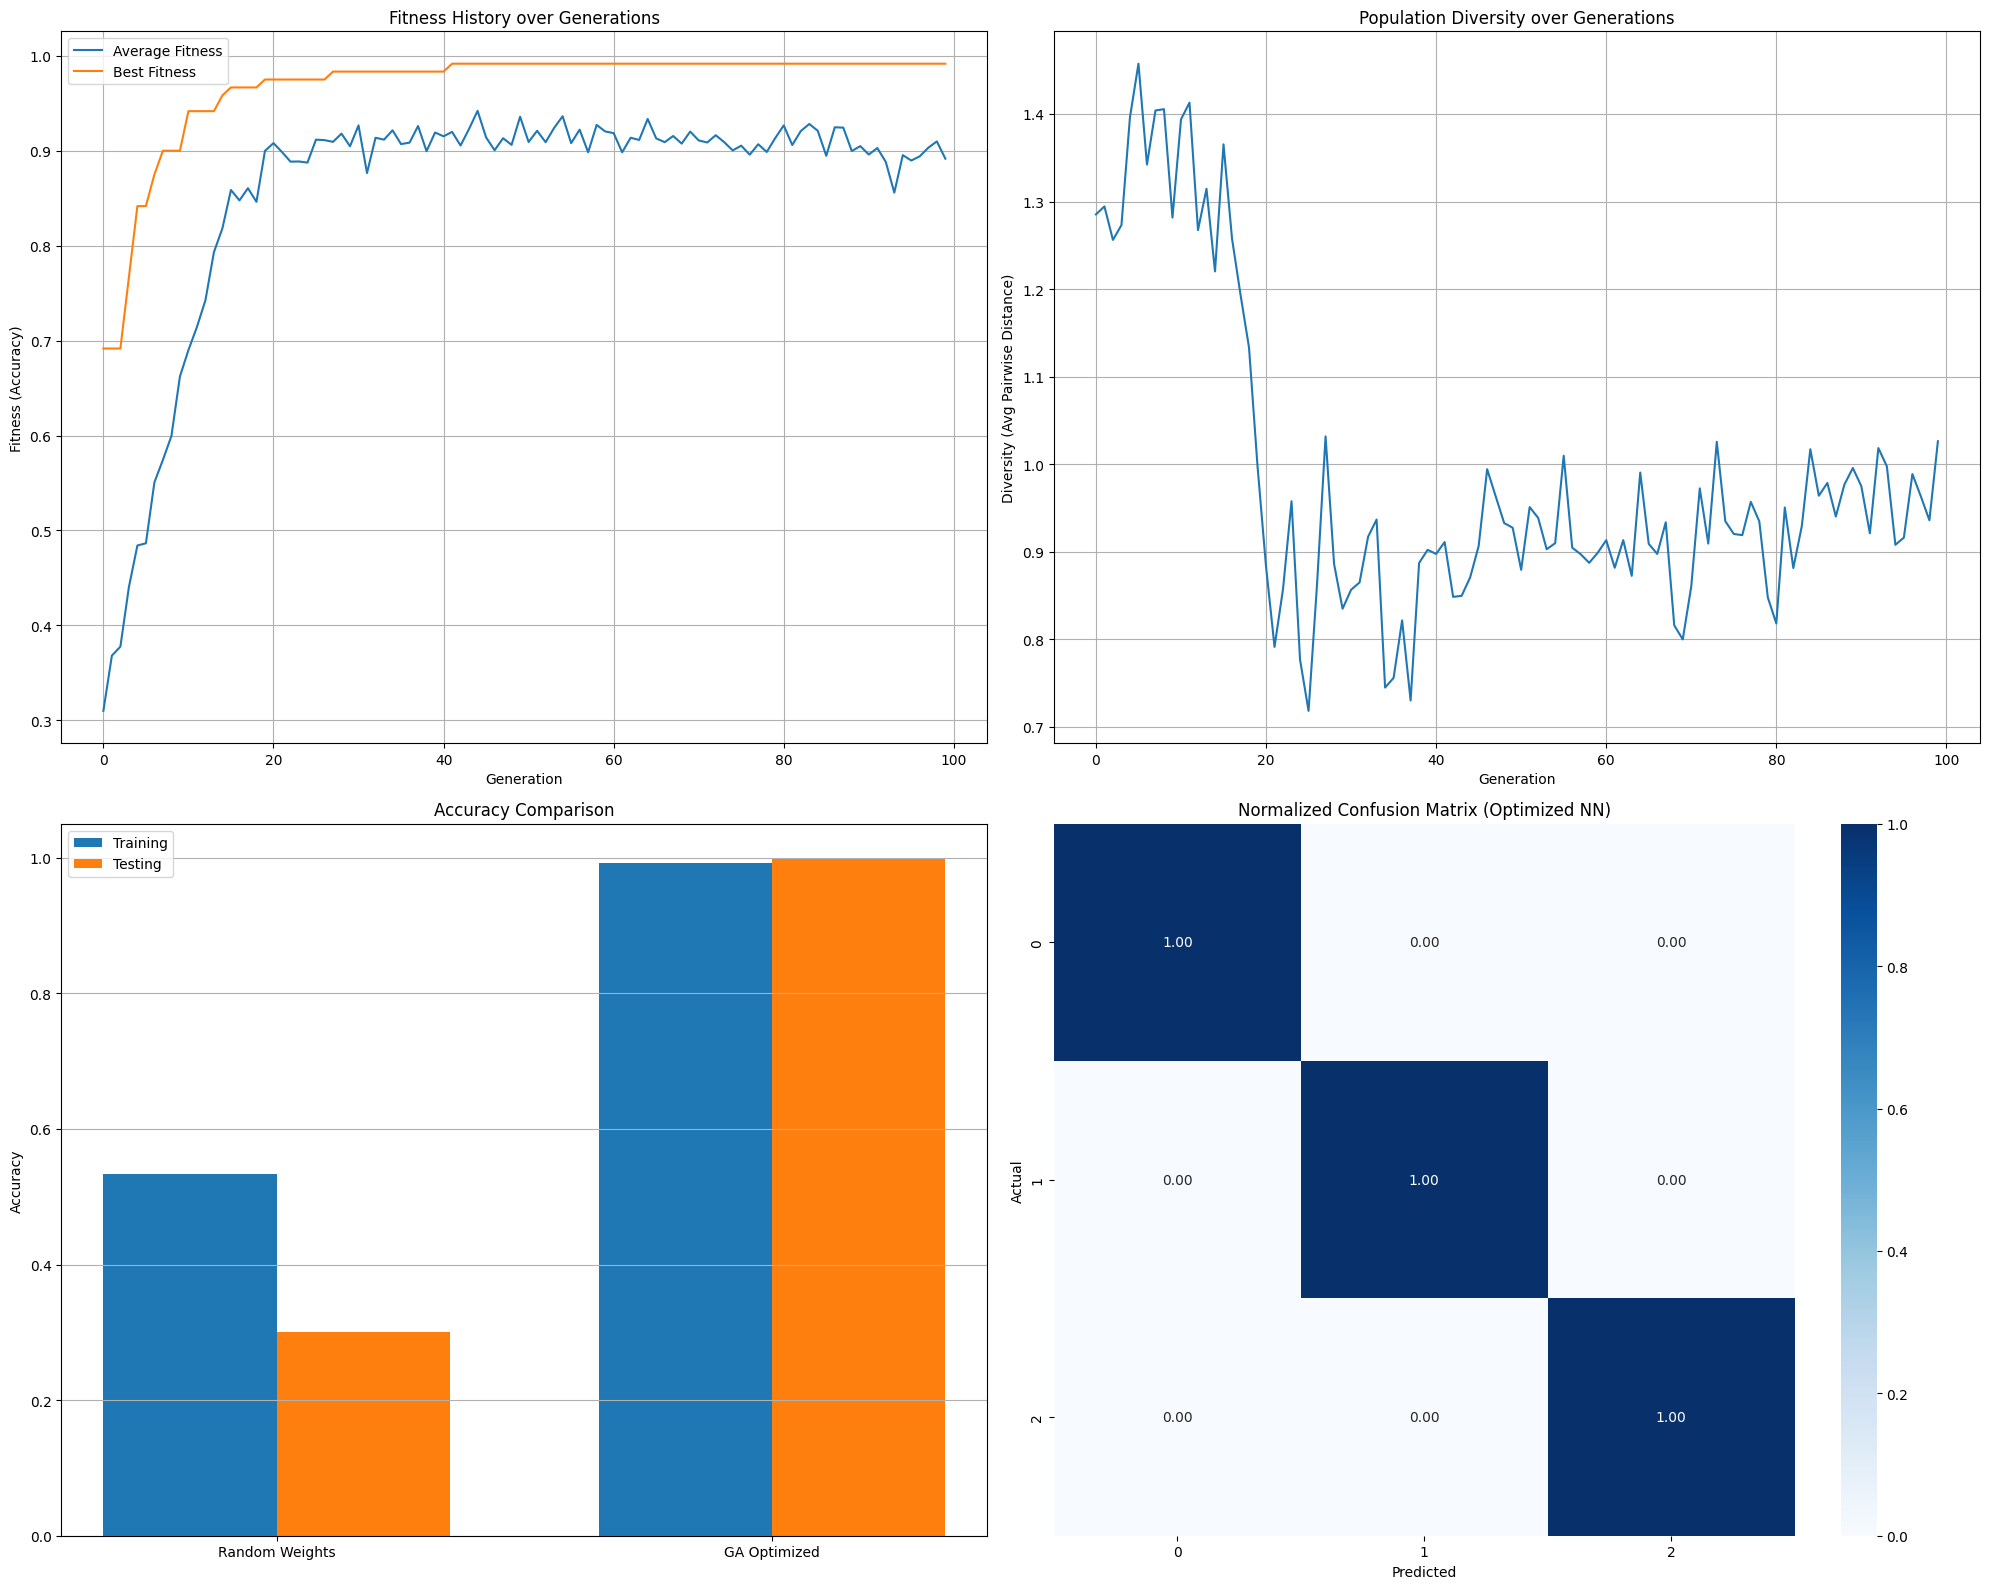


Running hyperparameter tuning for GA...


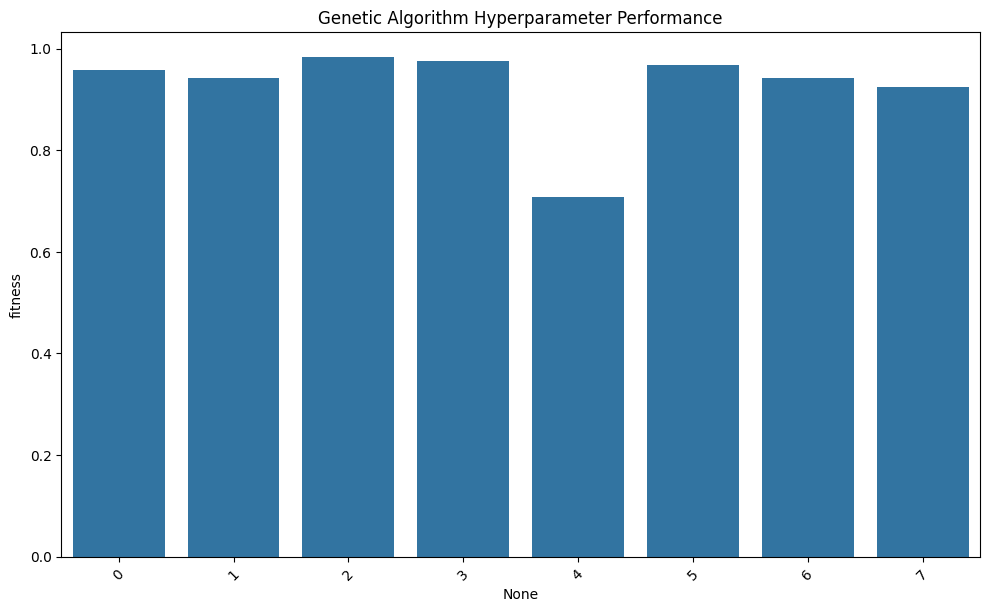


Comparing different optimization methods...


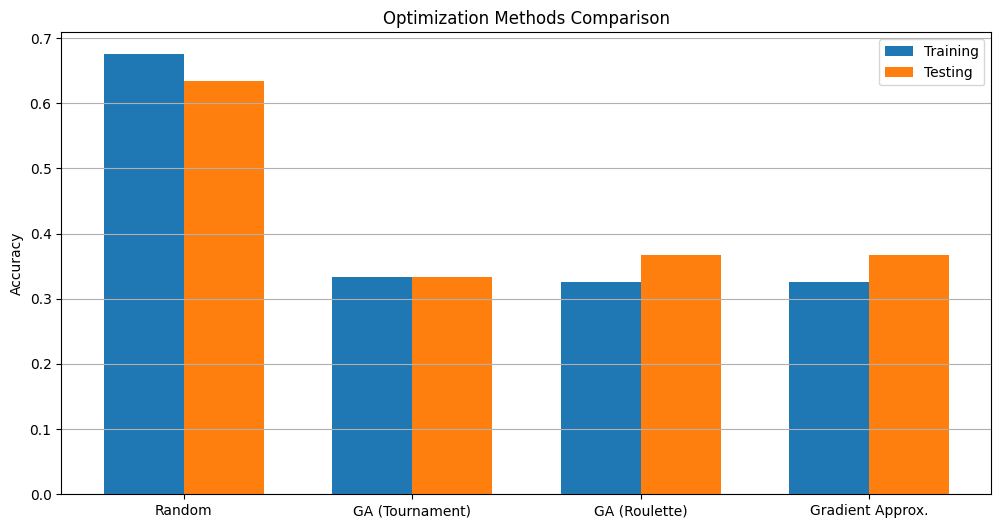


Visualizing weight dynamics during training...


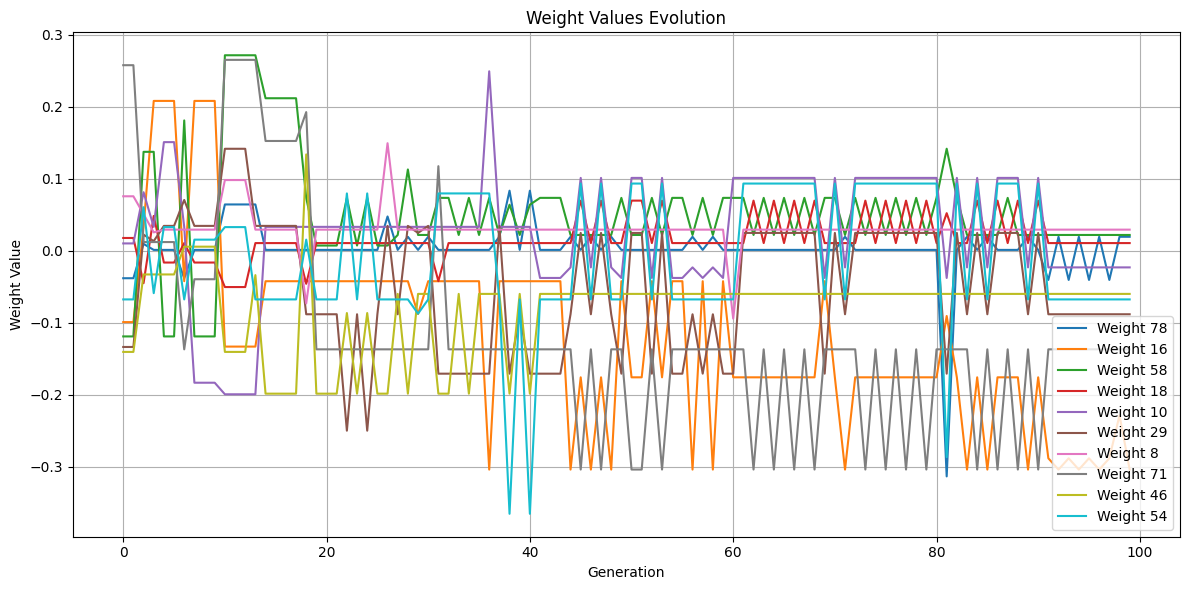

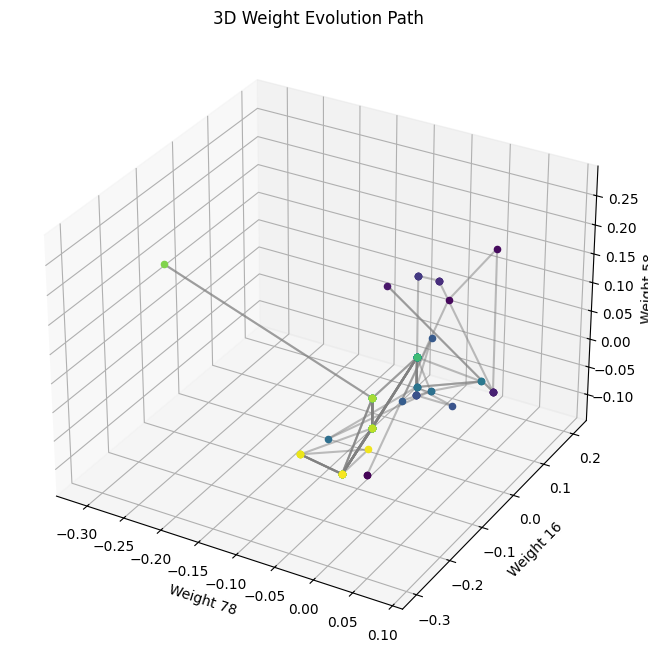

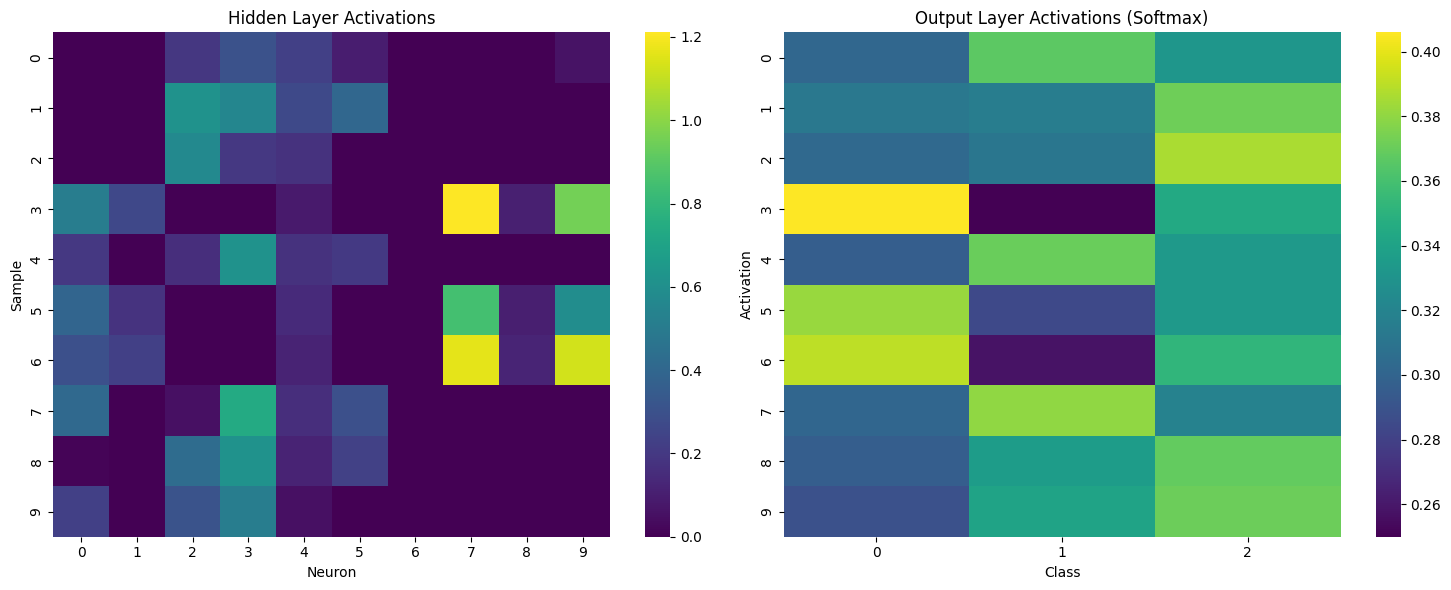


Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


=== Performance Summary ===
Dataset: iris
Neural Network: 4-10-3
Random Weights - Train: 0.5333, Test: 0.3000
GA Optimized  - Train: 0.9917, Test: 1.0000
Improvement   - Train: 0.4583, Test: 0.7000


In [12]:
# Main execution code
def run_ga_experiment(dataset_name='iris', hidden_size=10, population_size=50,
                      mutation_rate=0.1, selection_method='tournament',
                      crossover_method='uniform', generations=100):

    print(f"Loading {dataset_name} dataset...")
    X, y, n_classes = load_dataset(dataset_name)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize features
    X_mean = X_train.mean(axis=0)
    X_std = X_train.std(axis=0) + 1e-8
    X_train_norm = (X_train - X_mean) / X_std
    X_test_norm = (X_test - X_mean) / X_std

    # Prepare for multi-class classification if needed
    if n_classes > 2:
        output_size = n_classes

        # One-hot encode targets
        encoder = OneHotEncoder(sparse_output=False, categories='auto')
        y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
        y_test_onehot = encoder.transform(y_test.reshape(-1, 1))
    else:
        output_size = 1
        y_train_onehot = None
        y_test_onehot = None

    print(f"Dataset info: {X_train.shape[0]} train samples, {X_test.shape[0]} test samples")
    print(f"Input dimensions: {X_train.shape[1]}, Output dimensions: {output_size}")

    # Initialize neural network
    input_size = X_train.shape[1]
    nn = NeuralNetwork(input_size, hidden_size, output_size)

    # Save initial random weights
    initial_weights = nn.get_weights().copy()
    # Calculate accuracy with random weights
    if output_size == 1:
        random_predictions = nn.predict(X_train_norm)
        random_accuracy_train = accuracy_score(y_train, random_predictions)
        random_predictions = nn.predict(X_test_norm)
        random_accuracy_test = accuracy_score(y_test, random_predictions)
    else:
        random_predictions = nn.predict(X_train_norm, 'relu')
        random_accuracy_train = accuracy_score(y_train, random_predictions)
        random_predictions = nn.predict(X_test_norm, 'relu')
        random_accuracy_test = accuracy_score(y_test, random_predictions)

    print(f"Accuracy with random weights - Training: {random_accuracy_train:.4f}, Testing: {random_accuracy_test:.4f}")

    # Initialize genetic algorithm
    print(f"Initializing genetic algorithm with population size: {population_size}, mutation rate: {mutation_rate}")
    print(f"Selection method: {selection_method}, Crossover method: {crossover_method}")
    num_weights = len(nn.get_weights())
    ga = GeneticAlgorithm(population_size, num_weights,
                        mutation_rate=mutation_rate,
                        selection_method=selection_method,
                        crossover_method=crossover_method)

    # Run evolution
    print(f"Running genetic algorithm for {generations} generations...")
    best_weights, history = ga.evolve(nn, X_train_norm, y_train, generations=generations, y_onehot=y_train_onehot)

    # Set the best weights to the neural network
    nn.set_weights(best_weights)

    # Calculate accuracy with optimized weights
    if output_size == 1:
        optimized_predictions = nn.predict(X_train_norm)
        optimized_accuracy_train = accuracy_score(y_train, optimized_predictions)
        optimized_predictions = nn.predict(X_test_norm)
        optimized_accuracy_test = accuracy_score(y_test, optimized_predictions)
    else:
        optimized_predictions = nn.predict(X_train_norm, 'relu')
        optimized_accuracy_train = accuracy_score(y_train, optimized_predictions)
        optimized_predictions = nn.predict(X_test_norm, 'relu')
        optimized_accuracy_test = accuracy_score(y_test, optimized_predictions)

    print(f"Accuracy with GA optimized weights - Training: {optimized_accuracy_train:.4f}, Testing: {optimized_accuracy_test:.4f}")
    print(f"Improvement - Training: {optimized_accuracy_train - random_accuracy_train:.4f}, Testing: {optimized_accuracy_test - random_accuracy_test:.4f}")

    # Visualization section
    print("\n=== Detailed Analysis and Visualizations ===")

    # 1. Training progress visualization
    plt.figure(figsize=(20, 16))

    # Plot fitness history
    plt.subplot(2, 2, 1)
    plt.plot(history['avg_fitness'], label='Average Fitness')
    plt.plot(history['max_fitness'], label='Best Fitness')
    plt.title('Fitness History over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Fitness (Accuracy)')
    plt.legend()
    plt.grid(True)

    # Plot population diversity
    plt.subplot(2, 2, 2)
    plt.plot(history['diversity'])
    plt.title('Population Diversity over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Diversity (Avg Pairwise Distance)')
    plt.grid(True)

    # Plot accuracy comparison
    plt.subplot(2, 2, 3)
    labels = ['Random Weights', 'GA Optimized']
    train_accuracies = [random_accuracy_train, optimized_accuracy_train]
    test_accuracies = [random_accuracy_test, optimized_accuracy_test]

    x = np.arange(len(labels))
    width = 0.35

    plt.bar(x - width/2, train_accuracies, width, label='Training')
    plt.bar(x + width/2, test_accuracies, width, label='Testing')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison')
    plt.xticks(x, labels)
    plt.legend()
    plt.grid(True, axis='y')

    # Plot confusion matrices
    plt.subplot(2, 2, 4)
    if output_size == 1:
        cm = confusion_matrix(y_test, optimized_predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Confusion Matrix (Optimized NN)')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
    else:
        # For multi-class, normalize the confusion matrix
        cm = confusion_matrix(y_test, optimized_predictions)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
        plt.title('Normalized Confusion Matrix (Optimized NN)')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

    plt.tight_layout()
    plt.savefig('ga_training_progress.png')
    plt.show()
########################## under testing #####################################
    # # 2. Visualize neural network architecture
    # print("\nVisualizing Neural Network Architecture...")
    # visualize_nn_architecture(nn)

    # # 3. Dimension reduction for visualization
    # print("\nGenerating reduced dimension visualization...")
    # if X_train_norm.shape[1] > 2:
    #     # Use t-SNE for dimensionality reduction
    #     tsne = TSNE(n_components=2, random_state=42)
    #     X_train_2d = tsne.fit_transform(X_train_norm)

    #     # Plot decision boundaries
    #     plt.figure(figsize=(20, 8))

    #     # Random weights
    #     plt.subplot(1, 2, 1)
    #     nn.set_weights(initial_weights)

    #     # Create a mesh grid for visualization
    #     h = 0.1
    #     x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
    #     y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
    #     xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    #     # For t-SNE we need to make predictions on the original space
    #     # This is just for visualization, so we'll use an approximation
    #     # by finding nearest neighbors in the 2D space
    #     from sklearn.neighbors import KNeighborsClassifier

    #     # Train a KNN on the 2D embeddings
    #     knn = KNeighborsClassifier(n_neighbors=5)
    #     knn.fit(X_train_2d, np.argmax(random_predictions, axis=1))

    #     # Predict on the mesh grid
    #     Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    #     Z = Z.reshape(xx.shape)

    #     plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdBu)
    #     plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=plt.cm.RdBu, edgecolor='k')
    #     plt.title(f'Decision Regions with Random Weights (Accuracy: {random_accuracy_train:.4f})')
    #     plt.xlabel('t-SNE Feature 1')
    #     plt.ylabel('t-SNE Feature 2')

    #     # Optimized weights
    #     plt.subplot(1, 2, 2)
    #     nn.set_weights(best_weights)

    #     # For optimized weights, use the same approach
    #     knn = KNeighborsClassifier(n_neighbors=5)
    #     knn.fit(X_train_2d, optimized_predictions)

    #     Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    #     Z = Z.reshape(xx.shape)

    #     plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdBu)
    #     plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=plt.cm.RdBu, edgecolor='k')
    #     plt.title(f'Decision Regions with Optimized Weights (Accuracy: {optimized_accuracy_train:.4f})')
    #     plt.xlabel('t-SNE Feature 1')
    #     plt.ylabel('t-SNE Feature 2')

    #     plt.tight_layout()
    #     plt.savefig('decision_boundaries.png')
    #     plt.show()


########################## under testing #####################################
    # 4. Hyperparameter tuning results
    print("\nRunning hyperparameter tuning for GA...")
    hyperparams_results = hypertune_ga(X_train_norm, y_train, nn, num_weights)

    plt.figure(figsize=(10, 6))
    # Plot hyperparameter combinations sorted by fitness
    hyperparams_results = hyperparams_results.sort_values('fitness', ascending=False)
    sns.barplot(x=hyperparams_results.index, y='fitness', data=hyperparams_results)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.title('Genetic Algorithm Hyperparameter Performance')
    plt.savefig('hyperparameter_tuning.png')
    plt.show()

    # 5. Compare with other optimization methods
    print("\nComparing different optimization methods...")
    optimization_results = compare_optimization_methods(X_train_norm, y_train, X_test_norm, y_test,
                                                      input_size, hidden_size, output_size)

    # Plot comparison
    plt.figure(figsize=(12, 6))
    methods = list(optimization_results.keys())
    train_accuracies = [optimization_results[method]['train'] for method in methods]
    test_accuracies = [optimization_results[method]['test'] for method in methods]

    x = np.arange(len(methods))
    width = 0.35

    plt.bar(x - width/2, train_accuracies, width, label='Training')
    plt.bar(x + width/2, test_accuracies, width, label='Testing')
    plt.ylabel('Accuracy')
    plt.title('Optimization Methods Comparison')
    plt.xticks(x, methods)
    plt.legend()
    plt.grid(True, axis='y')
    plt.savefig('optimization_comparison.png')
    plt.show()

    # 6. Weight dynamics visualization
    print("\nVisualizing weight dynamics during training...")
    plot_weight_dynamics(history, nn)

    # 7. Activation visualization for the final model
    plt.figure(figsize=(15, 6))
    nn.set_weights(best_weights)

    # Sample a few data points
    sample_indices = np.random.choice(len(X_train_norm), min(10, len(X_train_norm)), replace=False)
    X_sample = X_train_norm[sample_indices]
    y_sample = y_train[sample_indices]

    # Get activations
    _ = nn.forward(X_sample, 'relu' if output_size > 1 else 'sigmoid')
    activations = nn.activations

    # Plot hidden layer activations
    plt.subplot(1, 2, 1)
    sns.heatmap(activations[0], cmap='viridis')
    plt.title('Hidden Layer Activations')
    plt.xlabel('Neuron')
    plt.ylabel('Sample')

    # Plot output layer activations
    plt.subplot(1, 2, 2)
    if output_size > 1:
        sns.heatmap(activations[1], cmap='viridis')
        plt.title('Output Layer Activations (Softmax)')
    else:
        plt.bar(range(len(sample_indices)), activations[1].flatten())
        plt.axhline(y=0.5, color='r', linestyle='-')
        plt.title('Output Layer Activations (Sigmoid)')
    plt.xlabel('Class' if output_size > 1 else 'Sample')
    plt.ylabel('Activation')

    plt.tight_layout()
    plt.savefig('activation_visualization.png')
    plt.show()

    # 8. Create interactive widgets for Colab
    if IS_COLAB:
        print("\nCreating interactive widgets...")

        # Widget for selecting dataset
        dataset_widget = widgets.Dropdown(
            options=['synthetic', 'iris', 'digits'],
            value=dataset_name,
            description='Dataset:',
            disabled=False,
        )

        # Widget for hidden layer size
        hidden_size_widget = widgets.IntSlider(
            value=hidden_size,
            min=5,
            max=30,
            step=5,
            description='Hidden Size:',
            disabled=False,
        )

        # Widget for population size
        population_widget = widgets.IntSlider(
            value=population_size,
            min=10,
            max=100,
            step=10,
            description='Population:',
            disabled=False,
        )

        # Widget for mutation rate
        mutation_widget = widgets.FloatSlider(
            value=mutation_rate,
            min=0.01,
            max=0.3,
            step=0.01,
            description='Mutation:',
            disabled=False,
        )

        # Widget for selection method
        selection_widget = widgets.Dropdown(
            options=['tournament', 'roulette'],
            value=selection_method,
            description='Selection:',
            disabled=False,
        )

        # Widget for crossover method
        crossover_widget = widgets.Dropdown(
            options=['single', 'uniform'],
            value=crossover_method,
            description='Crossover:',
            disabled=False,
        )

        # Widget for generations
        generations_widget = widgets.IntSlider(
            value=generations,
            min=10,
            max=200,
            step=10,
            description='Generations:',
            disabled=False,
        )

        # Create button to run experiment
        run_button = widgets.Button(
            description='Run Experiment',
            disabled=False,
            button_style='success',
            tooltip='Click to run the experiment with these parameters',
            icon='play'
        )

        output = widgets.Output()

        # Function to run when button is clicked
        def on_button_clicked(b):
            with output:
                clear_output()
                print("Running experiment with selected parameters...")
                run_ga_experiment(
                    dataset_name=dataset_widget.value,
                    hidden_size=hidden_size_widget.value,
                    population_size=population_widget.value,
                    mutation_rate=mutation_widget.value,
                    selection_method=selection_widget.value,
                    crossover_method=crossover_widget.value,
                    generations=generations_widget.value
                )

        run_button.on_click(on_button_clicked)

        # Display widgets
        print("Use the interactive widgets below to experiment with different parameters:")
        display(dataset_widget)
        display(widgets.HBox([hidden_size_widget, population_widget]))
        display(widgets.HBox([mutation_widget, generations_widget]))
        display(widgets.HBox([selection_widget, crossover_widget]))
        display(run_button)
        display(output)

    # 9. Generate a detailed classification report
    nn.set_weights(best_weights)
    if output_size == 1:
        y_pred = nn.predict(X_test_norm)
    else:
        y_pred = nn.predict(X_test_norm, 'relu')

    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))

    # 10. Summary statistics
    print("\n=== Performance Summary ===")
    print(f"Dataset: {dataset_name}")
    print(f"Neural Network: {input_size}-{hidden_size}-{output_size}")
    print(f"Random Weights - Train: {random_accuracy_train:.4f}, Test: {random_accuracy_test:.4f}")
    print(f"GA Optimized  - Train: {optimized_accuracy_train:.4f}, Test: {optimized_accuracy_test:.4f}")
    print(f"Improvement   - Train: {optimized_accuracy_train - random_accuracy_train:.4f}, Test: {optimized_accuracy_test - random_accuracy_test:.4f}")

    # # If this is the main script, run the experiment
    # if __name__ == "__main__":
    #     # Default parameters
    #     run_ga_experiment(
    #         dataset_name='iris',
    #         hidden_size=10,
    #         population_size=50,
    #         mutation_rate=0.1,
    #         selection_method='tournament',
    #         crossover_method='uniform',
    #         generations=100
    #     )
run_ga_experiment(
        dataset_name='iris',
        hidden_size=10,
        population_size=50,
        mutation_rate=0.1,
        selection_method='tournament',
        crossover_method='uniform',
        generations=100
)